Import Libraries and Packages

In [13]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import opendatasets as od
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Data Extraction

In [14]:
# Download the dataset
dataset_url = 'https://www.kaggle.com/datasets/msambare/fer2013'
od.download(dataset_url)

# Define dataset paths
train_path = "fer2013/train"
val_path = "fer2013/test"

Skipping, found downloaded files in ".\fer2013" (use force=True to force download)


Data Pre-Processing

In [15]:
# Initialize data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data
batch_size = 64
target_size = (48, 48)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=target_size,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [16]:
# Define the number of classes
num_classes = 7

model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Model compilation
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 4, 4, 128)       

CNN Algorithm

In [17]:
# Define the number of classes
num_classes = 7

def create_model():
    # New Model architecture with additional convolutional layers
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Model compilation
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

K-Fold Cross Validation & Confusion Matrix

In [18]:
# K-Fold Cross Validation with 80:20 split
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Initialize dictionaries to store metrics for each emotion
accuracy_dict = {emotion: [] for emotion in emotion_labels}
precision_dict = {emotion: [] for emotion in emotion_labels}
recall_dict = {emotion: [] for emotion in emotion_labels}
f1_score_dict = {emotion: [] for emotion in emotion_labels}

# Get the list of filenames and corresponding classes
filenames = train_generator.filenames
classes = train_generator.classes

# Split the data into training and validation sets with an 80:20 ratio
train_files, val_files, train_classes, val_classes = train_test_split(
    filenames, classes, test_size=0.2, stratify=classes, random_state=42
)

# Loop through each fold
for fold, (train_indices, val_indices) in enumerate(skf.split(train_files, train_classes)):
    print(f"Fold {fold+1}/{skf.n_splits}")

    # Split data into training and validation sets for the current fold
    train_files_fold = [train_files[i] for i in train_indices]
    train_classes_fold = [train_classes[i] for i in train_indices]
    val_files_fold = [train_files[i] for i in val_indices]
    val_classes_fold = [train_classes[i] for i in val_indices]

    # Create dataframes for the current fold
    train_df = pd.DataFrame({'filename': train_files_fold, 'class': train_classes_fold}).astype(str)
    val_df = pd.DataFrame({'filename': val_files_fold, 'class': val_classes_fold}).astype(str)

    # Create model for each fold
    model = create_model()

    # Create data generators for the current fold
    train_generator_fold = train_datagen.flow_from_dataframe(
        train_df,
        directory=train_path,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator_fold = val_datagen.flow_from_dataframe(
        val_df,
        directory=train_path,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False
    )

    # Train the model
    history = model.fit(
        train_generator_fold,
        epochs=10,
        validation_data=val_generator_fold,
        verbose=1
    )

    # Evaluate the model on validation set for each fold
    val_metrics = model.evaluate(
        val_generator_fold,
        verbose=0
    )
    val_loss, val_acc, val_precision, val_recall = val_metrics[0], val_metrics[1], val_metrics[2], val_metrics[3]
    
    # Calculate F1-score
    if val_precision + val_recall == 0:
        val_f1_score = 0
    else:
        val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)

    # Generate confusion matrix for this fold
    y_pred = model.predict(val_generator_fold)
    y_true = val_generator_fold.classes
    conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

    # Calculate metrics for each emotion
    for i, emotion in enumerate(emotion_labels):
        tp = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tp
        fn = np.sum(conf_matrix[i, :]) - tp
        tn = np.sum(conf_matrix) - (tp + fp + fn)

        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        accuracy_dict[emotion].append(accuracy)
        precision_dict[emotion].append(precision)
        recall_dict[emotion].append(recall)
        f1_score_dict[emotion].append(f1_score)

    # Print metrics for each emotion
    for emotion in emotion_labels:
        print(f"Metrics for {emotion}:")
        print(f"Average Validation Accuracy: {np.mean(accuracy_dict[emotion]) * 100:.2f}%")
        print(f"Average Validation Precision: {np.mean(precision_dict[emotion]) * 100:.2f}%")
        print(f"Average Validation Recall: {np.mean(recall_dict[emotion]) * 100:.2f}%")
        print(f"Average Validation F1-score: {np.mean(f1_score_dict[emotion]) * 100:.2f}%")
        print()

# Print overall average metrics
print("Overall Average Metrics:")
print(f"Average Validation Accuracy: {np.mean([np.mean(accuracy_dict[emotion]) for emotion in emotion_labels]) * 100:.2f}%")
print(f"Average Validation Precision: {np.mean([np.mean(precision_dict[emotion]) for emotion in emotion_labels]) * 100:.2f}%")
print(f"Average Validation Recall: {np.mean([np.mean(recall_dict[emotion]) for emotion in emotion_labels]) * 100:.2f}%")
print(f"Average Validation F1-score: {np.mean([np.mean(f1_score_dict[emotion]) for emotion in emotion_labels]) * 100:.2f}%")


Fold 1/10
Found 20670 validated image filenames belonging to 7 classes.
Found 2297 validated image filenames belonging to 7 classes.
Epoch 1/10
323/323 [==============================] - 99s 293ms/step - loss: 1.8313 - accuracy: 0.2443 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 1.8163 - val_accuracy: 0.2512 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/10
323/323 [==============================] - 87s 270ms/step - loss: 1.8221 - accuracy: 0.2480 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 1.8144 - val_accuracy: 0.2512 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/10
323/323 [==============================] - 98s 304ms/step - loss: 1.8172 - accuracy: 0.2496 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 1.8064 - val_accuracy: 0.2512 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/10
323/323 [==============================] - 102s 315ms/step - loss: 1.8062 - accuracy: 0.2521 - precisio

Confusion Matrix

Confusion Matrix:
[[ 35   0   5 194  18  43  25]
 [  1   0   0  28   1   3   2]
 [ 29   0   7 197  11  42  41]
 [ 14   0   4 509  11  22  17]
 [ 16   0   0 277  33  56  15]
 [ 24   0   6 242  26  73  16]
 [ 13   0   3  95   9  19 114]]


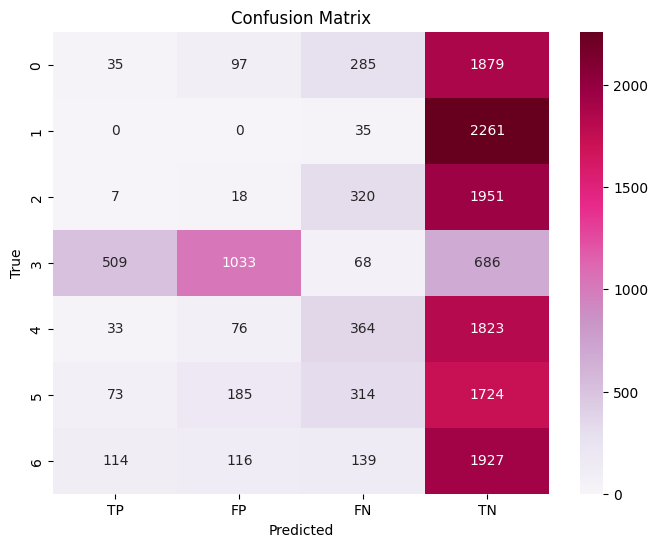

In [19]:
# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Create a DataFrame for the confusion matrix
conf_df = pd.DataFrame({'TP': np.diag(conf_matrix),
                        'FP': np.sum(conf_matrix, axis=0) - np.diag(conf_matrix),
                        'FN': np.sum(conf_matrix, axis=1) - np.diag(conf_matrix),
                        'TN': np.sum(conf_matrix) - (np.diag(conf_matrix) + (np.sum(conf_matrix, axis=0) - np.diag(conf_matrix)) + (np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)))})

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, cmap='PuRd', fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()